# Import the data and libralies

In [2]:
from matplotlib import pyplot as plt
!pip install japanize-matplotlib
import japanize_matplotlib
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from datetime import datetime
!pip install adjustText
from adjustText import adjust_text
import seaborn as sns
import statsmodels as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import *
from scipy.stats import t as t_dist
from scipy.stats import describe
import itertools

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet

import warnings
warnings.simplefilter('ignore')

path = "/content/drive/MyDrive/ds_portfolio/num_suicide_japan/data"

# Import the user-defined modules
import sys
sys.path.append(path+'/../src')
import tsa_economic_effects, conducting_EDA, preprocessing_ts
from tsa_economic_effects import * 
from conducting_EDA import *
from preprocessing_ts import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
nation = pd.DataFrame({"num_suicide": pd.read_pickle(path+"/02_intermediate/nation_suicide.pickle")})

# Time Series Analysis

In [4]:
# Split the data into before_COVID and with_COVID
train_start = "2015-01"
train_end = "2020-02"
test_start = "2020-03"
test_end = "2022-02"

# Num of lags to be considered
DV_shifts = 0

## Nation wide

### Prophet

#### Uni

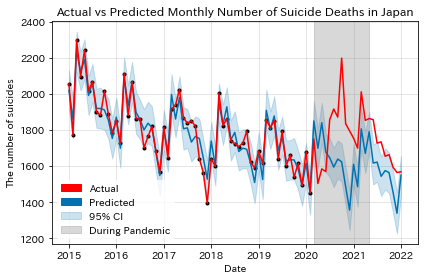

In [8]:
# Create the dataset for Prophet
full = nation.reset_index().rename({"Date": "ds", "num_suicide": "y"}, axis=1)[["ds", "y"]].set_index("ds")
full[full.columns[~full.columns.isin(["y"])]] = full.drop("y",axis=1).shift(DV_shifts)
full_preprocessed = full[DV_shifts:]


# Split the data into train and test and reset the index
train = full_preprocessed[train_start: train_end].reset_index()
test = full_preprocessed[test_start: test_end].reset_index()

# Instantiate the model
prophet_uni = Prophet(interval_width=0.95, weekly_seasonality=False, daily_seasonality=False)

# Fit the train data to the model
prophet_uni.fit(train)

# Create the future dataframe
future_uni = prophet_uni.make_future_dataframe(periods=23, freq="MS")

# Make a predicition
forecast_uni = prophet_uni.predict(future_uni)

# Plot Actual VS Prediction
fig, ax = plt.subplots()
prophet_uni.plot(forecast_uni, ax=ax)
ax.plot(full_preprocessed[train_start: test_end]["y"], label="Actual", color="r")
ax.set_title("Actual vs Predicted Monthly Number of Suicide Deaths in Japan")
ax.set_xlabel("Date")
ax.set_ylabel("The number of suicides")
ax.axvspan(datetime(2020,3,1), datetime(2021,4,30), color='gray', alpha=0.3)
red_patch = mpatches.Patch(color='red', label='Actual')
blue_patch = mpatches.Patch(color='#0072B2', label='Predicted')
skyblue_patch = mpatches.Patch(color='#0072B2', alpha=0.2, label='95% CI')
gray_patch = mpatches.Patch(color='gray', alpha=0.3, label='During Pandemic')
ax.legend(handles=[red_patch, blue_patch, skyblue_patch, gray_patch]).get_frame().set_linewidth(0.0001)
fig.tight_layout()
plt.savefig(path+"/08_reporting/num_suicide.png", format="png", dpi=1000);